In [1]:
# Load data and packages
import CEEMDAN_LSTM as cl
import csv
from collections import Counter
from datetime import datetime, timedelta
import folium
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import math
import numpy as np
#from EMD import EMD
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pmdarima as pm
from pmdarima import auto_arima
# import PyEMD
# from PyEMD import EMD
# import pywt
import random
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def fill_missing_events(df):
    df_filled_list = []
    
    for center in df['sorting_center_name'].unique():
        df_center = df[df['sorting_center_name'] == center]
        output_belts = df_center['output_belt'].unique()
        
        min_date = df_center['scanning_date'].min()
        max_date = df_center['scanning_date'].max()

        all_dates = pd.date_range(start=pd.Timestamp(year=min_date.year, month=1, day=1), end=pd.Timestamp(year=max_date.year, month=max_date.month, day=1) + pd.offsets.MonthEnd(0))
        
        all_combinations = pd.MultiIndex.from_product(
            [[center], all_dates, output_belts],
            names=['sorting_center_name', 'scanning_date', 'output_belt']
        )
        
        all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
        df_filled_center = pd.merge(all_combinations_df, df_center, 
                                    on=['sorting_center_name', 'scanning_date', 'output_belt'], 
                                    how='left')
        
        df_filled_center['no_of_events'] = df_filled_center['no_of_events'].fillna(0.0001)
        df_filled_list.append(df_filled_center)
    
    df_filled = pd.concat(df_filled_list, ignore_index=True)
    
    return df_filled

In [3]:
def prepare_data(df):
    # Data cleaning
    print("Number of rows original dataset is: " + str(df.shape[0]))

    df = df.loc[df["event_type"] == "LAJ", :]
    df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
    df.dropna(inplace = True)
    df['output_belt'] = df['output_belt'].astype(int)
    df = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index = False)['no_of_events'].sum()
    df['scanning_date'] = pd.to_datetime(df['scanning_date'])

    # We add 0 events for all dates without orders 
    df = fill_missing_events(df)

    print("Number of rows cleaned dataset is: " + str(df.shape[0]))

    # Data preparation
    df['day'] = df['scanning_date'].dt.day
    df['month'] = df['scanning_date'].dt.month
    df['weekday'] = df['scanning_date'].dt.dayofweek + 1
    df['week'] = df['scanning_date'].dt.isocalendar().week
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    df['yearday'] = df['scanning_date'].dt.day_of_year
    df['weekday_sin'] = np.sin(df['weekday'] / 7 * 2 * np.pi)
    df['weekday_cos'] = np.cos(df['weekday'] / 7 * 2 * np.pi)

    return df

In [4]:
# Data loading
directory_path = os.getcwd() + "\\Data\\sorting_event_volumes_2023.csv"

df = pd.read_csv(directory_path)
df = prepare_data(df)

Number of rows original dataset is: 8949721
Number of rows cleaned dataset is: 243090


## Neural network

In [32]:
def plot_forecast(starting_date, planning_horizon, forecasts, model, train = pd.DataFrame([]), test = pd.DataFrame([])):
    fig = go.Figure()
    starting_date = datetime.strptime(starting_date, "%d-%m-%Y")
    scanning_dates = pd.date_range(start=starting_date, periods=planning_horizon).strftime('%Y-%m-%d').tolist()
    if test.shape[0] == 0:
        fig.add_trace(go.Scatter(x=scanning_dates, y=forecasts["forecasts"], name="Forecast"))
    if test.shape[0] > 0:
        fig.add_trace(go.Scatter(x=train["scanning_date"], y=train["no_of_events"], name="Train"))
        fig.add_trace(go.Scatter(x=test["scanning_date"], y=test["no_of_events"], name="Test"))
        fig.add_trace(go.Scatter(x=scanning_dates, y=forecasts["forecasts"], name="Forecast"))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=model,
                      width=650, title_x=0.5, height=400, xaxis_title="scanning_date",
                      yaxis_title="no_of_events")
    
    return fig.show()

In [21]:
class EventDataset(Dataset):
    def __init__(self, df):
        self.data = df  
        one_hot_columns = [col for col in self.data.columns if col.startswith('output_belt_')]
        feature_columns = one_hot_columns + ['day', 'weekday', 'week_of_month', 'mult']
        self.inputs = torch.tensor(self.data[feature_columns].values.astype(int), dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values.astype(float), dtype=torch.float32)
        self.yearday = torch.tensor(self.data['yearday'].values.astype(int), dtype=torch.long)
        self.output_belt = torch.tensor(self.data['output_belt'].values.astype(int), dtype=torch.long)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

def create_dataloaders_for_df(df, planning_horizon = 14, batch_size=128):
    train_df = df[df["month"] <= 9]
    test_df = df[(df["month"] == 10) & (df["day"] <= planning_horizon)]
    train_loader = DataLoader(EventDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(EventDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2*128)
        self.fc2 = nn.Linear(2*128, 2*128)
        self.fc3 = nn.Linear(2*128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        x1 = self.swish(self.fc1(x))
        x2 = self.swish(self.fc2(x1)) + x1  # Skip connection
        x3 = self.swish(self.fc3(x2))
        x4 = self.swish(self.fc4(x3)) + x3  # Skip connection
        x5 = self.swish(self.fc5(x4))
        output = self.fc6(x5)
        return output

Training model for KUOPIO
Epoch [1/100], Train Loss: 71.0702, Test Loss: 48.9738, MSE: 23135.2767, MAE: 112.6681, LR: 0.001000
Epoch [2/100], Train Loss: 36.5677, Test Loss: 25.3170, MSE: 10674.8580, MAE: 60.8392, LR: 0.001000
Epoch [3/100], Train Loss: 26.1408, Test Loss: 22.5960, MSE: 7870.3819, MAE: 50.8295, LR: 0.001000
Epoch [4/100], Train Loss: 24.5190, Test Loss: 21.7298, MSE: 6768.7405, MAE: 51.1675, LR: 0.001000
Epoch [5/100], Train Loss: 22.8728, Test Loss: 20.5479, MSE: 5955.3331, MAE: 45.7236, LR: 0.001000
Epoch [6/100], Train Loss: 22.0687, Test Loss: 19.3983, MSE: 6339.2298, MAE: 47.7930, LR: 0.001000
Epoch [7/100], Train Loss: 21.3988, Test Loss: 19.3163, MSE: 5881.9928, MAE: 46.2620, LR: 0.001000
Epoch [8/100], Train Loss: 21.0941, Test Loss: 19.6800, MSE: 5990.7174, MAE: 45.7667, LR: 0.001000
Epoch [9/100], Train Loss: 21.1856, Test Loss: 19.4098, MSE: 5605.6065, MAE: 44.3236, LR: 0.001000
Epoch [10/100], Train Loss: 20.5708, Test Loss: 18.5512, MSE: 5432.8075, MAE: 44

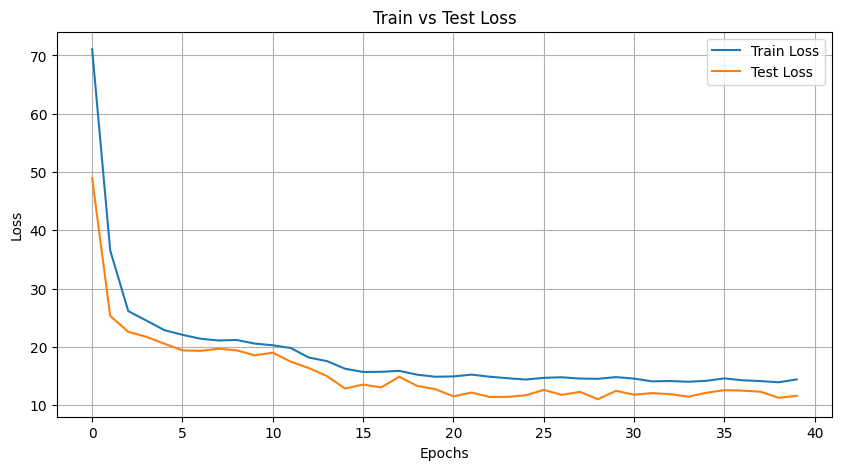

Training model for LIETO
Epoch [1/100], Train Loss: 111.9322, Test Loss: 82.6547, MSE: 58668.5027, MAE: 199.2356, LR: 0.001000
Epoch [2/100], Train Loss: 70.3727, Test Loss: 48.3474, MSE: 32204.3552, MAE: 122.4170, LR: 0.001000
Epoch [3/100], Train Loss: 45.6771, Test Loss: 41.2723, MSE: 32698.3577, MAE: 114.9257, LR: 0.001000
Epoch [4/100], Train Loss: 40.7166, Test Loss: 36.2238, MSE: 26792.0219, MAE: 101.1372, LR: 0.001000
Epoch [5/100], Train Loss: 38.1179, Test Loss: 34.4358, MSE: 22433.2905, MAE: 87.8456, LR: 0.001000
Epoch [6/100], Train Loss: 37.1022, Test Loss: 33.6144, MSE: 26849.8469, MAE: 99.3975, LR: 0.001000
Epoch [7/100], Train Loss: 36.2238, Test Loss: 32.3607, MSE: 23846.5139, MAE: 92.6119, LR: 0.001000
Epoch [8/100], Train Loss: 34.9291, Test Loss: 31.7356, MSE: 15975.0828, MAE: 76.7558, LR: 0.001000
Epoch [9/100], Train Loss: 35.0113, Test Loss: 31.3397, MSE: 18836.4197, MAE: 84.5089, LR: 0.001000
Epoch [10/100], Train Loss: 35.4023, Test Loss: 35.3948, MSE: 27719.20

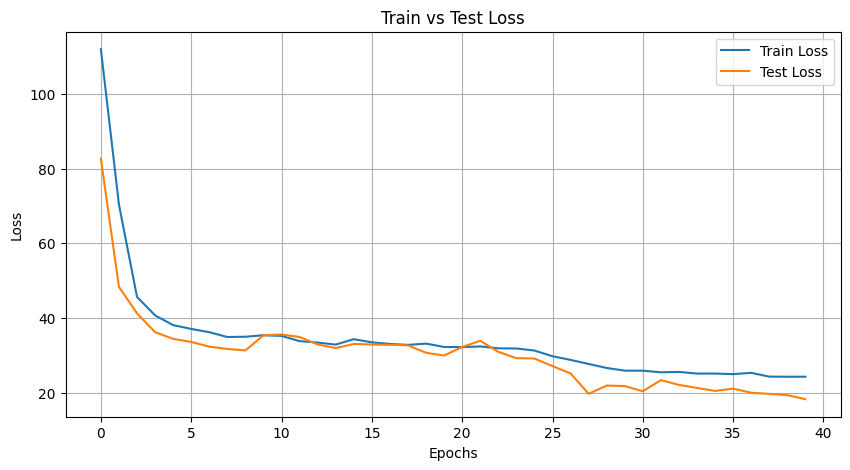

Training model for OULU
Epoch [1/100], Train Loss: 70.5662, Test Loss: 58.9101, MSE: 25808.7712, MAE: 120.6735, LR: 0.001000
Epoch [2/100], Train Loss: 42.3411, Test Loss: 27.7094, MSE: 12964.9321, MAE: 73.8643, LR: 0.001000
Epoch [3/100], Train Loss: 26.6577, Test Loss: 26.1631, MSE: 7969.0452, MAE: 54.5562, LR: 0.001000
Epoch [4/100], Train Loss: 23.5583, Test Loss: 23.0979, MSE: 6171.6398, MAE: 46.7499, LR: 0.001000
Epoch [5/100], Train Loss: 21.8550, Test Loss: 20.1999, MSE: 6458.7743, MAE: 46.6162, LR: 0.001000
Epoch [6/100], Train Loss: 20.2060, Test Loss: 18.9032, MSE: 5235.1863, MAE: 43.6444, LR: 0.001000
Epoch [7/100], Train Loss: 20.5927, Test Loss: 19.0700, MSE: 5123.8548, MAE: 41.8952, LR: 0.001000
Epoch [8/100], Train Loss: 18.7796, Test Loss: 18.3326, MSE: 5774.9066, MAE: 42.6783, LR: 0.001000
Epoch [9/100], Train Loss: 18.4055, Test Loss: 17.3812, MSE: 3481.1788, MAE: 36.2137, LR: 0.001000
Epoch [10/100], Train Loss: 16.8151, Test Loss: 15.8920, MSE: 2636.9529, MAE: 31.4

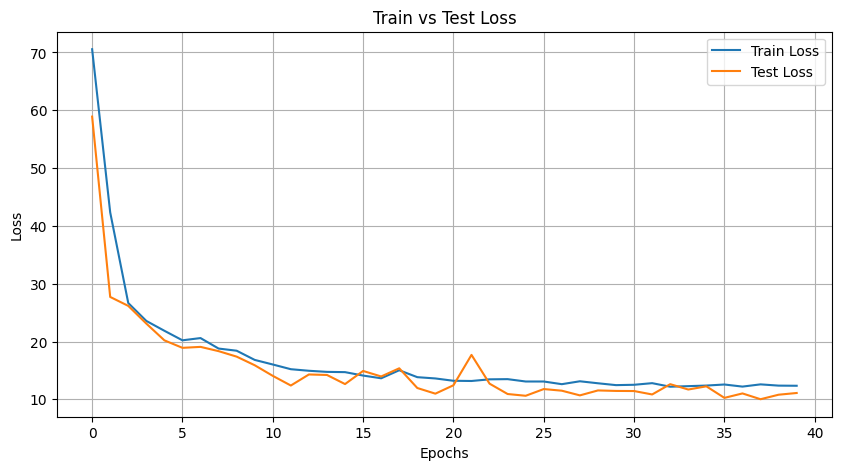

Training model for SEINÄJOKI
Epoch [1/100], Train Loss: 254.6234, Test Loss: 264.0482, MSE: 259104.6836, MAE: 411.9807, LR: 0.001000
Epoch [2/100], Train Loss: 154.4355, Test Loss: 141.8335, MSE: 128987.8418, MAE: 300.2907, LR: 0.001000
Epoch [3/100], Train Loss: 122.8580, Test Loss: 120.5057, MSE: 115258.0508, MAE: 281.5393, LR: 0.001000
Epoch [4/100], Train Loss: 108.7593, Test Loss: 107.0290, MSE: 82771.6680, MAE: 239.9170, LR: 0.001000
Epoch [5/100], Train Loss: 99.8612, Test Loss: 97.2038, MSE: 66716.9873, MAE: 212.0201, LR: 0.001000
Epoch [6/100], Train Loss: 91.1233, Test Loss: 86.6600, MSE: 57103.8242, MAE: 190.8719, LR: 0.001000
Epoch [7/100], Train Loss: 82.1651, Test Loss: 85.2579, MSE: 48416.0166, MAE: 175.0744, LR: 0.001000
Epoch [8/100], Train Loss: 76.4230, Test Loss: 67.5068, MSE: 49960.3535, MAE: 163.5185, LR: 0.001000
Epoch [9/100], Train Loss: 70.9097, Test Loss: 64.3690, MSE: 43928.1909, MAE: 150.1749, LR: 0.001000
Epoch [10/100], Train Loss: 62.4768, Test Loss: 61.

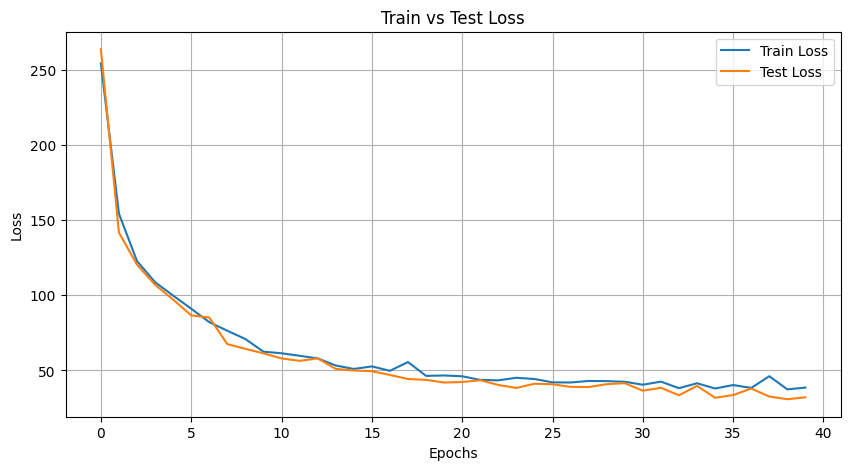

Training model for TAMPERE
Epoch [1/100], Train Loss: 89.1883, Test Loss: 66.1250, MSE: 54277.4515, MAE: 134.4950, LR: 0.001000
Epoch [2/100], Train Loss: 51.9381, Test Loss: 39.8549, MSE: 31956.7009, MAE: 76.7790, LR: 0.001000
Epoch [3/100], Train Loss: 37.1318, Test Loss: 31.9855, MSE: 25200.7827, MAE: 64.6413, LR: 0.001000
Epoch [4/100], Train Loss: 32.7745, Test Loss: 28.0148, MSE: 19347.6599, MAE: 55.6352, LR: 0.001000
Epoch [5/100], Train Loss: 30.4755, Test Loss: 23.1893, MSE: 15130.2809, MAE: 54.0006, LR: 0.001000
Epoch [6/100], Train Loss: 26.1031, Test Loss: 20.6720, MSE: 9741.5118, MAE: 41.6769, LR: 0.001000
Epoch [7/100], Train Loss: 21.8468, Test Loss: 21.2143, MSE: 23896.9422, MAE: 64.7674, LR: 0.001000
Epoch [8/100], Train Loss: 20.9683, Test Loss: 18.2676, MSE: 18572.6179, MAE: 54.6264, LR: 0.001000
Epoch [9/100], Train Loss: 19.8299, Test Loss: 16.5083, MSE: 12883.2421, MAE: 34.0938, LR: 0.001000
Epoch [10/100], Train Loss: 18.4672, Test Loss: 12.8630, MSE: 7703.2559, 

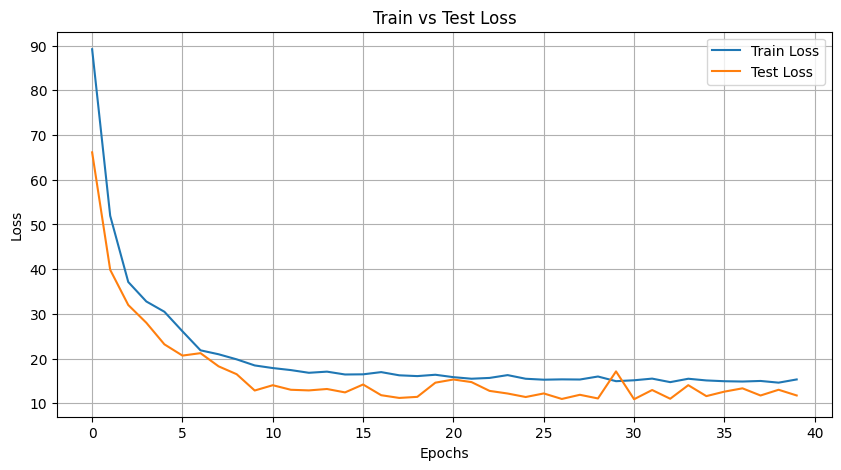

Training model for VANTAA
Epoch [1/100], Train Loss: 335.5691, Test Loss: 287.7412, MSE: 1324079.5092, MAE: 569.1865, LR: 0.001000
Epoch [2/100], Train Loss: 205.6488, Test Loss: 168.8608, MSE: 917248.6817, MAE: 343.4099, LR: 0.001000
Epoch [3/100], Train Loss: 145.7978, Test Loss: 149.1487, MSE: 843700.7513, MAE: 340.2142, LR: 0.001000
Epoch [4/100], Train Loss: 132.6533, Test Loss: 134.6110, MSE: 701034.2400, MAE: 277.5802, LR: 0.001000
Epoch [5/100], Train Loss: 122.9625, Test Loss: 124.7242, MSE: 591669.7621, MAE: 252.7177, LR: 0.001000
Epoch [6/100], Train Loss: 113.9431, Test Loss: 117.0100, MSE: 460388.9903, MAE: 222.6178, LR: 0.001000
Epoch [7/100], Train Loss: 100.1792, Test Loss: 98.5785, MSE: 336628.6305, MAE: 243.5365, LR: 0.001000
Epoch [8/100], Train Loss: 90.2600, Test Loss: 86.1690, MSE: 322145.2689, MAE: 217.4129, LR: 0.001000
Epoch [9/100], Train Loss: 87.4628, Test Loss: 83.7224, MSE: 277004.7076, MAE: 183.9685, LR: 0.001000
Epoch [10/100], Train Loss: 85.3354, Test 

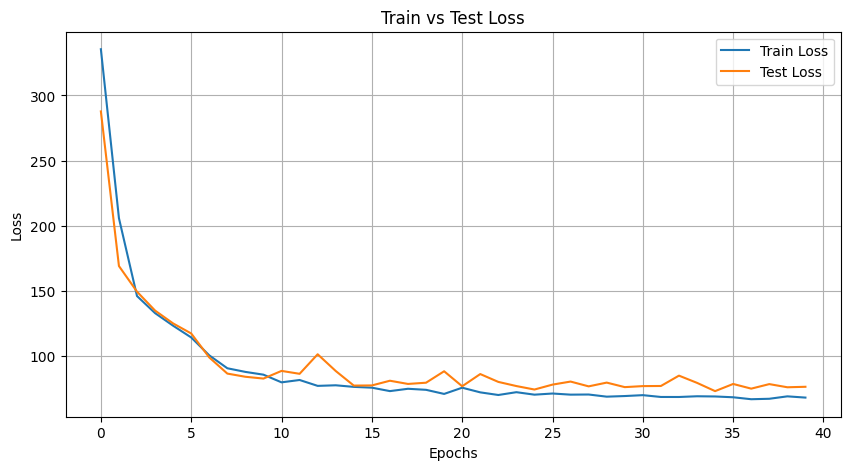

In [40]:
def plot_losses(train_losses, test_losses, sorting_center_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss for sorting center {}'.format(sorting_center_name))
    plt.legend()
    plt.grid(True)
    plt.show()

class QuantileLoss(nn.Module):
    def __init__(self, tau):
        super(QuantileLoss, self).__init__()
        self.tau = tau
    
    def forward(self, outputs, targets):
        errors = targets - outputs
        loss = torch.max(self.tau * errors, (self.tau - 1) * errors)
        return loss.mean()
tau = 0.7  # Kies een waarde voor tau (0.5 is de mediaan)
criterion = QuantileLoss(tau=tau)

def train_model(sorting_center_name, model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=20, min_delta=0.1):
    # Initialize dictionaries to store daily errors for each sorting center and output belt
    daily_errors = {}

    train_losses, test_losses = [], []
    early_stopping_counter = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _, _ in train_loader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_loss = 0.0
        total_mse = 0.0
        total_mae = 0.0

        # Reset daily errors for each epoch
        daily_errors = {}

        with torch.no_grad():
            for inputs, targets, output_belts, days in test_loader:
                inputs, targets = inputs.float().to(device), targets.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                mse = nn.MSELoss()(outputs, targets)
                mae = nn.L1Loss()(outputs, targets)
                total_loss += loss.item()
                total_mse += mse.item()
                total_mae += mae.item()
                
                # Calculate and record individual errors
                for i in range(len(targets)):
                    actual = targets[i].item()
                    forecast = outputs[i].item()
                    day = days[i].item()
                    output_belt = output_belts[i].item()

                    squared_difference = (actual - forecast) ** 2
                    absolute_difference = abs(actual - forecast)

                    if day not in daily_errors:
                        daily_errors[day] = {'mse': [], 'mae': []}

                    daily_errors[day]['mse'].append(squared_difference)
                    daily_errors[day]['mae'].append(absolute_difference)
        
        avg_test_loss = total_loss / len(test_loader)
        avg_test_mse = total_mse / len(test_loader)
        avg_test_mae = total_mae / len(test_loader)
        test_losses.append(avg_test_loss)

        current_lr = optimizer.param_groups[0]['lr']
        
        if sorting_center_name == "VANTAA":
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
                f'MSE: {avg_test_mse:.4f}, MAE: {avg_test_mae:.4f}, LR: {current_lr:.6f}')

        mse = {}
        mae = {}
        for day, errors in daily_errors.items():
            mse[day] = sum(errors["mse"]) / len(errors["mse"])
            mae[day] = sum(errors["mae"]) / len(errors["mae"])

        # Calculate MSE, VSE, and MAE metrics across days
        MSE_avg = sum(mse.values()) / len(mse)
        VSE = np.var(list(mse.values()), ddof=1)
        MAE_avg = sum(mae.values()) / len(mae)
        
        # Early stopping op basis van de agressievere criteria
        if epoch >= patience:
            if avg_test_loss > min(test_losses[-patience:]) - min_delta:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0    
            if early_stopping_counter >= patience:
                if sorting_center_name == "VANTAA":
                    print(f'Early stopping na {epoch + 1} epochs.')
                break
    
    if sorting_center_name == "KUOPIO":
        mode = "w"
    else:
        mode = "a"

    with open("Results/results_NN.csv", mode=mode, newline='') as file:
        writer = csv.writer(file)
        if mode == "w":
            writer.writerow(['Sorting center', 'MSE', 'VSE', 'MAE'])

        writer.writerow([sorting_center_name, MSE_avg, VSE, MAE_avg])

    return model, train_losses, test_losses, daily_errors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_NN = df.copy()
df_NN['mult'] = df_NN['day'] * df_NN['weekday'] * df_NN['week_of_month']
df_NN['sum'] = df_NN['day'] + df_NN['weekday'] + df_NN['week_of_month']

daily_errors = {}
planning_horizon = 14

sorting_center_names = df_NN["sorting_center_name"].unique()
start = datetime.now()

# Directory to save loaders (make sure it exists or create it)
save_dir_load = "Data/loaders NN/"
save_dir_models = "Data/models NN/"

for sorting_center_name in sorting_center_names:
    df_sorting_center = df_NN[df_NN["sorting_center_name"] == sorting_center_name]
    one_hot_belt = pd.get_dummies(df_sorting_center['output_belt'], prefix='output_belt').astype(int)
    df_sorting_center = pd.concat([df_sorting_center, one_hot_belt], axis=1)

    train_loader, test_loader = create_dataloaders_for_df(df_sorting_center)
    input_dim = next(iter(train_loader))[0].shape[1]
    model = SimpleNN(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    if sorting_center_name == "VANTAA":
        print(f'Training model for {sorting_center_name}')
    model, train_losses, test_losses, daily_errors_sorting_center = train_model(
        sorting_center_name,
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        epochs=100,
        patience=20,
        min_delta=0.1
    )

    daily_errors[sorting_center_name] = daily_errors_sorting_center
    
    if sorting_center_name == "VANTAA":
        plot_losses(train_losses, test_losses, sorting_center_name)

    # Save train and test loaders
    torch.save(train_loader, f"{save_dir_load}{sorting_center_name}_train_loader.pth")
    torch.save(test_loader, f"{save_dir_load}{sorting_center_name}_test_loader.pth")

    # Save the model's state_dict
    torch.save(model.state_dict(), f"{save_dir_models}{sorting_center_name}_model.pth")

daily_mse = {}
daily_mae = {}

for day in daily_errors[sorting_center_name].keys():
    mse = 0
    mae = 0
    n_output_belts = 0
    for sorting_center_name in sorting_center_names:
        mse += sum(daily_errors[sorting_center_name][day]["mse"])
        mae += sum(daily_errors[sorting_center_name][day]["mae"])
        n_output_belts += len(daily_errors[sorting_center_name][day]["mse"])
    daily_mse[day] = mse / n_output_belts
    daily_mae[day] = mae / n_output_belts

MSE = sum(daily_mse.values()) / len(daily_mse)
VSE = np.var(list(daily_mse.values()), ddof=1)
MAE = sum(daily_mae.values()) / len(daily_mae)

with open("Results/results_NN.csv", mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["total", MSE, VSE, MAE])
        
with open("Results/results_general.csv", mode='a', newline='') as file:
    writer = csv.writer(file)

    end = datetime.now()
    running_time = end - start

    writer.writerow(['Neural Network', MSE, VSE, MAE, running_time])

In [23]:
from datetime import datetime, timedelta

def generate_prediction_data(start_date, planning_horizon, df_sorting_center, output_belt):
    # Get unique output_belts and the index of the given output_belt for one-hot encoding
    output_belts = sorted(df_sorting_center["output_belt"].unique())
    belt_index = np.where(output_belts == output_belt)[0][0]
    
    # Initialize one-hot encoded array for output_belt
    one_hot_output_belt = np.zeros(len(output_belts))
    one_hot_output_belt[belt_index] = 1  # Set the corresponding position to 1

    x_data = []
    current_date = datetime.strptime(start_date, "%d-%m-%Y")
    end_date = current_date + timedelta(days=planning_horizon - 1)  # End date based on planning horizon
    
    while current_date <= end_date:
        day = current_date.day  # Dag van de maand
        weekday = current_date.isoweekday()  # Weekdag (1=maandag, 7=zondag)
        
        week_of_month = (current_date.day - 1) // 7 + 1
        
        # Calculate 'mult'
        mult = day * weekday * week_of_month
        
        # Concatenate one-hot output belt with other features into a single flat array
        x_data.append(np.concatenate((one_hot_output_belt, [day, weekday, week_of_month, mult])))
        current_date += timedelta(days=1)  # Ga naar de volgende dag

    return np.array(x_data)

#def predict_and_plot_for_belt(models, loaders, df, starting_date, planning_horizon):
def forecast_NN(starting_date, planning_horizon, df):
    forecast_dict = {}
    sorting_center_names = df["sorting_center_name"].unique()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # paths
    save_dir_loaders = "Data/loaders NN/"
    save_dir_models = "Data/models NN/"    

    for sorting_center_name in sorting_center_names:
        # load loaders
        train_loader = torch.load(f"{save_dir_loaders}{sorting_center_name}_train_loader.pth")
        test_loader = torch.load(f"{save_dir_loaders}{sorting_center_name}_test_loader.pth")
        input_dim = next(iter(train_loader))[0].shape[1]

        # load model
        model = SimpleNN(input_dim)  # initialize the model architecture
        model.load_state_dict(torch.load(f"{save_dir_models}{sorting_center_name}_model.pth"))
        model.eval()

        df_sorting_center = df[df["sorting_center_name"] == sorting_center_name]
        output_belts = df_sorting_center["output_belt"].unique()

        for output_belt in output_belts:
            # Genereer predictie data
            x_data = generate_prediction_data(starting_date, planning_horizon, df_sorting_center, output_belt)
            x_tensor = torch.tensor(x_data).float().to(device)
            
            # Maak voorspellingen met het model
            with torch.no_grad():
                predictions = model(x_tensor).cpu().numpy().flatten()

            forecasts = pd.DataFrame(predictions)  # Convert Series to DataFrame
            forecasts.columns = ['forecasts']  # Rename the column to 'forecast

            # Round forecasts
            forecasts['forecasts'] = forecasts['forecasts'].round()

            if sorting_center_name == "VANTAA" and output_belt in [109]:
                plot_forecast(starting_date, planning_horizon, forecasts, "NN")

            if sorting_center_name not in forecast_dict:
                forecast_dict[sorting_center_name] = {}

            forecast_dict[sorting_center_name][output_belt] = forecasts

    return forecast_dict

## Dashboard

In [10]:
# Make the training functions for all models such that the training can be saved and used for prediction every time when needed

def train_model(data, model):
    data = prepare_data(data) # Ensure that data is ready for training

    if model == "Linear Regression":
        #train_LR(data)
        print("Training is finished")
    elif model == "ARIMA":
        #train_ARIMA(data)
        print("Training is finished")
    elif model == "Neural Network":
        #train_NN(data)
        print("Training is finished")
    '''elif model == "LSTM":
        #train_LSTM(data)
        print("Training is finished")'''

In [11]:
def make_forecast(start_date, planning_horizon, data, model):
    if model == "Linear Regression":
        #forecast = forecast_LR(start_date, planning_horizon, data)        
        print("Forecast finished")
    elif model == "ARIMA":
        #forecast = forecast_ARIMA(start_date, planning_horizon, data)
        print("Forecast finished")
    elif model == "Neural Network":
        forecast = forecast_NN(start_date, planning_horizon, data)
        print("Forecast finished")
    '''elif model == "LSTM":
        #forecast = forecast_LSTM(start_date, planning_horizon)           # If data is needed for forecast, then add to the function
        print("Forecast finished")'''
        
    return forecast

In [12]:
def save_forecast(start_date, planning_horizon, model, forecast):
    # Convert start_date from string to datetime using the format "DD-MM-YYYY"
    start_date = datetime.strptime(start_date, "%d-%m-%Y")

    # Generate dates for the forecast period
    dates = [(start_date + timedelta(days=day)).strftime("%Y-%m-%d") for day in range(planning_horizon)]

    for sorting_center_name, output_belts in forecast.items():
        # Define the file name
        file_name = f"Results/forecast_{model}_{sorting_center_name}.csv"

        # Open the file for writing
        with open(file_name, mode='w', newline='') as file:
            writer = csv.writer(file)
    
            # Write the header row (Dates)
            header = ['Output Belt'] + dates
            writer.writerow(header)
            
            # Write the forecast data
            for output_belt, forecasts in output_belts.items():
                if isinstance(forecasts, pd.DataFrame):
                    forecasts = forecasts.iloc[:, 0]
                row = [output_belt] + forecasts.tolist()  # Convert forecasts to list if it's a NumPy array
                writer.writerow(row)
    
    print("Forecasts successfully written to CSV files.")


In [13]:
def main(start_date, planning_horizon, data, model, train_indicator = False):
    if train_indicator == True:
        train_model(data, model)

    forecast = make_forecast(start_date, planning_horizon, data, model)

    save_forecast(start_date, planning_horizon, model, forecast)
    #plot_forecast(start_date, planning_horizon, prediction, model, data)   # Currently written to plot one output belt, so process it in the prediction function of your model

In [33]:
# Main
directory_path = os.getcwd() + "\\Data\\sorting_event_volumes_2023.csv"
df_forecast = df.copy()

# Input
start_date = "01-10-2023"                           # When does the planning horizon start
planning_horizon = 14                               # How long is the planning horizon
data = df_forecast[df_forecast["month"] <= 9]       # Always needed since some models need it for prediction
model = "Neural Network"                                     # Which model do you want to use, options are Linear Regression, ARIMA and Neural Network 
train_indicator = False                             # Optional, if you want to train the model

main(start_date, planning_horizon, data, model)

Forecast finished
Forecasts successfully written to CSV files.
